# Example Analysis: Uplift Modelling
This document contains an example of uplfit modelling on synthetic data. After training the model, I can use it to predict whether each individual in a test dataset will convert, and also identify the best treatment for that individual. This is applicable in areas like marketing (identifying which campaign is most successful for each person) or personalized medicine (identifying which drug or treatment is best for each person). 

## Set up

In [37]:
# load packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain
from causalml.metrics import auuc_score

from sklearn.model_selection import train_test_split

In [38]:
# simulate data
df, features = make_uplift_classification()

I simulated a dataset with 4000 rows and 19 features (or predictors), a binary response variable (conversion), and 4 groups (1 control, 3 treatments). If this were a real dataset, I'd also check impute any missing values using `KNNImputer` and normalize the feature variables.

In [39]:
# view dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   treatment_group_key  4000 non-null   object 
 1   x1_informative       4000 non-null   float64
 2   x2_informative       4000 non-null   float64
 3   x3_informative       4000 non-null   float64
 4   x4_informative       4000 non-null   float64
 5   x5_informative       4000 non-null   float64
 6   x6_irrelevant        4000 non-null   float64
 7   x7_irrelevant        4000 non-null   float64
 8   x8_irrelevant        4000 non-null   float64
 9   x9_irrelevant        4000 non-null   float64
 10  x10_irrelevant       4000 non-null   float64
 11  x11_uplift_increase  4000 non-null   float64
 12  x12_uplift_increase  4000 non-null   float64
 13  x13_increase_mix     4000 non-null   float64
 14  x14_uplift_increase  4000 non-null   float64
 15  x15_uplift_increase  4000 non-null   f

In [40]:
# view first few rows of dataframe
df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_irrelevant,...,x12_uplift_increase,x13_increase_mix,x14_uplift_increase,x15_uplift_increase,x16_increase_mix,x17_uplift_increase,x18_uplift_increase,x19_increase_mix,conversion,treatment_effect
0,control,-0.542888,1.976361,-0.531359,-2.354211,-0.380629,-2.614321,-0.128893,0.448689,-2.275192,...,-1.315304,0.742654,1.891699,-2.428395,1.541875,-0.817705,-0.610194,-0.591581,0,0
1,treatment3,0.258654,0.552412,1.434239,-1.422311,0.089131,0.790293,1.159513,1.578868,0.166540,...,-1.391878,-0.623243,2.443972,-2.889253,2.018585,-1.109296,-0.380362,-1.667606,0,0
2,treatment1,1.697012,-2.762600,-0.662874,-1.682340,1.217443,0.837982,1.042981,0.177398,-0.112409,...,-1.132497,1.050179,1.573054,-1.788427,1.341609,-0.749227,-2.091521,-0.471386,0,0
3,treatment2,-1.441644,1.823648,0.789423,-0.295398,0.718509,-0.492993,0.947824,-1.307887,0.123340,...,-2.084619,0.058481,1.369439,0.422538,1.087176,-0.966666,-1.785592,-1.268379,1,1
4,control,-0.625074,3.002388,-0.096288,1.938235,3.392424,-0.465860,-0.919897,-1.072592,-1.331181,...,-1.403984,0.760430,1.917635,-2.347675,1.560946,-0.833067,-1.407884,-0.781343,0,0


## Descriptives

In [41]:
# look at outcome rate & sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.511,1000
treatment1,0.514,1000
treatment2,0.559,1000
treatment3,0.600,1000
All,0.546,4000


Just eyeballing these numbers, it looks like treatment 1 doesn't differ from control in increasing conversion, treatment 2 has a small effect in increasing conversion, and treatment 3 has a larger effect in increasing conversion.

<Axes: xlabel='conversion', ylabel='Density'>

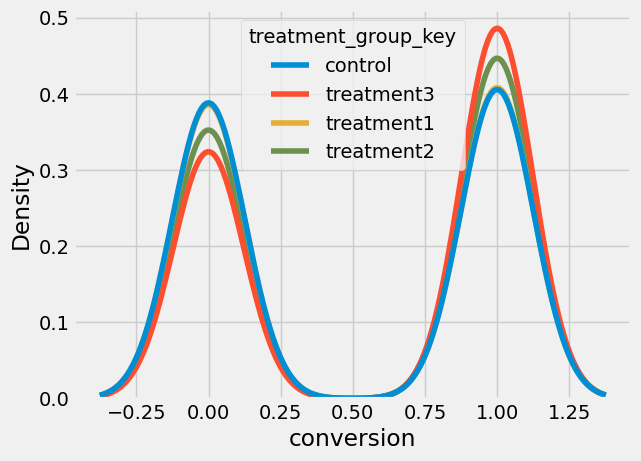

In [42]:
sns.kdeplot(data=df, x='conversion', hue='treatment_group_key')

Since the response variable is binary (1 for conversion, 0 for not), the distribution is centered around 0 and 1. I can clearly see the same pattern that the table above suggested: treatment 3 (the red line) has the highest proportion of conversions, followed by treatment 2. Treatment 1 appears completely indistinguishable from the control distribution, to the point where I can't even see the yellow line behind the blue one. 

## Train model

In [43]:
# split data into training & test sets
df_train, df_test = train_test_split(df, test_size=.2, random_state=1)

I wouldn't necessarily do feature selection if there are just 20 features in the dataset, but I'll do it here for the purposes of illustration.

In [44]:
# feature selection
# select top 10 features in the dataset by fitting a full model including all features first

full_model = UpliftRandomForestClassifier(control_name='control')

full_model.fit(df_train[features].values,
               treatment=df_train['treatment_group_key'].values,
               y=df_train['conversion'].values)

all_features = pd.Series(full_model.feature_importances_, index=features)

top10_features = all_features.sort_values(ascending=False)[:10]

top_features = top10_features.index.tolist()

In [45]:
# run uplift random forest classifier

uplift_model = UpliftRandomForestClassifier(control_name='control')

uplift_model.fit(df_train[top_features].values,
                 treatment = df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

## Visualize & assess model

### Feature importance

In [46]:
uplift_model_features = pd.Series(uplift_model.feature_importances_, index=top_features)
uplift_model_features = uplift_model_features.sort_values()
uplift_model_features

x17_uplift_increase    0.039319
x11_uplift_increase    0.044290
x12_uplift_increase    0.052824
x15_uplift_increase    0.064623
x8_irrelevant          0.070487
x6_irrelevant          0.071515
x2_informative         0.098900
x10_irrelevant         0.132702
x4_informative         0.160144
x18_uplift_increase    0.265196
dtype: float64

<Axes: >

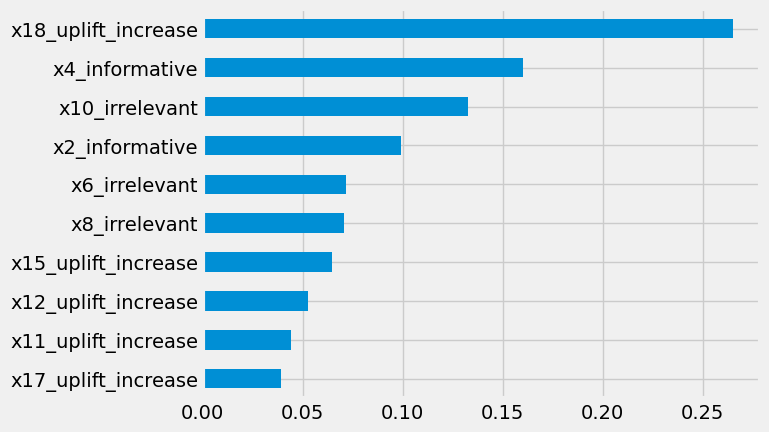

In [47]:
uplift_model_features.plot.barh()

## Uplift curve

In [48]:
# calculate predictions in test data
y_pred = uplift_model.predict(df_test[top_features].values)

result = pd.DataFrame(y_pred,
                      columns=uplift_model.classes_[1:])

# pull recommended treatment for each individual from model
best_treatment = np.where((result < 0).all(axis=1),
                          'control',
                          result.idxmax(axis=1))

# create indicator variables for whether an individual happened to receive the recommended treatment or was in the control group
actual_is_best = np.where(df_test['treatment_group_key'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['treatment_group_key'] == 'control', 1, 0)

# subset data for plotting
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

# generate metrics for uplift curve
auuc_metrics = (synth.assign(
    is_treated=1 - actual_is_control[synthetic],
    conversion=df_test.loc[synthetic,'conversion'].values,
    uplift_tree=synth.max(axis=1))
                .drop(columns=list(uplift_model.classes_[1:])))

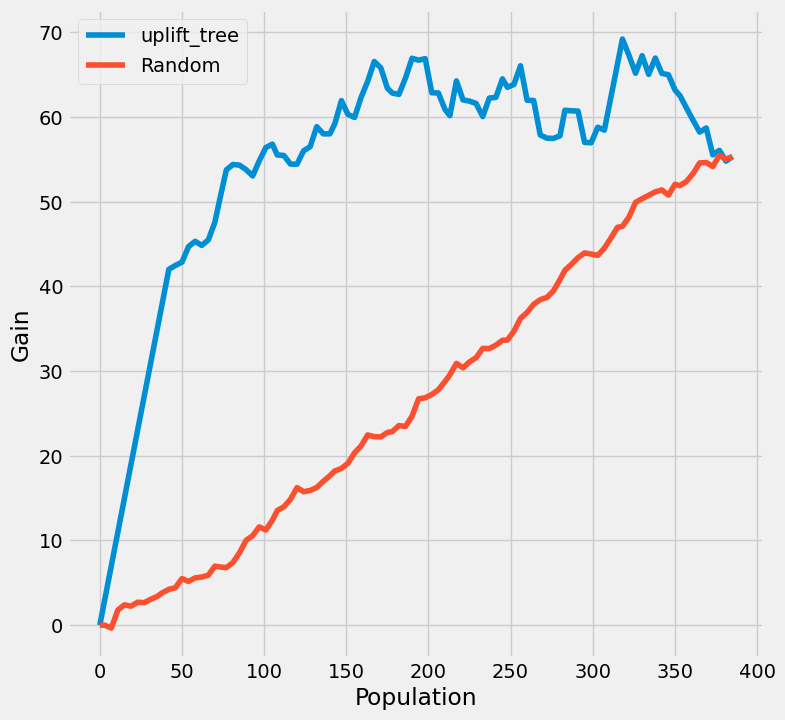

In [49]:
# plot uplift curve
plot_gain(auuc_metrics,
          outcome_col='conversion',
          treatment_col='is_treated')

The uplift curve (blue line) showed in the increase in conversion expected if individual is given their specific best treatment, compared giving individuals a random treatment (red line).

In [50]:
# calculate area under the curve
auuc = auuc_score(auuc_metrics,
                  outcome_col='conversion',
                  treatment_col='is_treated')
auuc

uplift_tree    0.991834
Random         0.483310
dtype: float64

The area under the uplift curve is very close to 1, compared to the area under the random curve being close to .5, indicated a good model fit.

We could then bring in new data (e,g., a new group of customers), use the model to predict the best treatment for each individual (e.g., the best marketing campaign), and then target the individuals accordingly. 